In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch.optim as optim

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

# Create datasets

## Data augmentation

In [5]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [6]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [7]:
trainset_orig = torchvision.datasets.ImageFolder("data/train", transform=train_transform)
testset= torchvision.datasets.ImageFolder("data/test", transform=test_transform)

## Split dataset to training and validation set

In [8]:
train_size = int(0.8 * len(trainset_orig))
val_size = len(trainset_orig) - train_size
trainset, valset = torch.utils.data.random_split(trainset_orig, [train_size, val_size])

In [9]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, num_workers=2, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, shuffle=False)

In [10]:
next(iter(trainloader))[0][0].shape # size of image

torch.Size([3, 64, 64])

### Show some random images

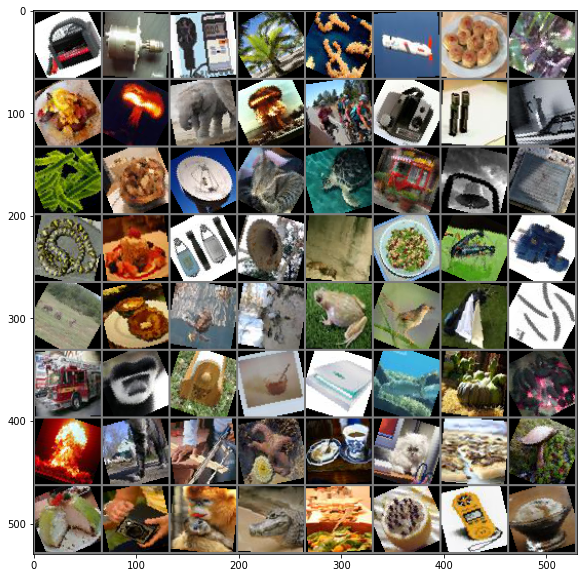

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
random_images, random_labels = dataiter.next()

# show images
plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(random_images))

Reference - calculate accuracy of random model

In [12]:
from collections import Counter
n_classes = dict(Counter(trainset_orig.targets))

In [13]:
f"{100* max(n_classes.values()) / sum(n_classes.values()):.3}%"

'2.05%'

# Make the convolutional neural network

### Help functions

In [14]:
def get_accuracy(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in loader:
            images, labels = data
            images = images.to(device)

            outputs = model(images).cpu()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct/total)

In [15]:
def plot_training(iters, losses, train_acc, test_acc):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, test_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')

    plt.show()

In [16]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3), stride=(1,1), padding=1)
        self.pool6 = nn.MaxPool2d(2, 2)
        self.bn6 = nn.BatchNorm2d(1024)

        self.fc1 = nn.Linear(1024 * 1 * 1, 400)
        self.drop1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(400, 300)
        self.drop2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(300, 50)

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.bn4(self.pool4(F.relu(self.conv4(x))))
        x = self.bn5(self.pool5(F.relu(self.conv5(x))))
        x = self.bn6(self.pool6(F.relu(self.conv6(x))))

        x = torch.flatten(x, 1)
        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [17]:
image_classifier = ImageClassifier().to(device)
image_classifier

ImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

# Train the convolutional neural network

In [18]:
LR = 0.001
EPOCHS = 35

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_classifier.parameters(), lr=LR, weight_decay=0.0001)

In [20]:
iters = []
losses = []
train_acc_ls = []
val_acc_ls = []

for epoch in range(EPOCHS):

    epoch_losses = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        image_classifier.train()
        optimizer.zero_grad()

        outputs = image_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    iters.append(epoch)
    loss_mean = np.array(epoch_losses).mean()
    losses.append(loss_mean)

    train_acc = get_accuracy(image_classifier, trainloader)
    val_acc = get_accuracy(image_classifier, valloader)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] loss: {loss_mean:.3} train_acc: {100*train_acc:.3}% val_acc: {100*val_acc:.3}%")

print('Finished Training')

[1/35] loss: 3.4 train_acc: 19.5% val_acc: 19.6%
[2/35] loss: 3.05 train_acc: 25.8% val_acc: 26.3%
[3/35] loss: 2.83 train_acc: 31.7% val_acc: 31.8%
[4/35] loss: 2.64 train_acc: 35.3% val_acc: 35.0%
[5/35] loss: 2.47 train_acc: 42.1% val_acc: 41.1%
[6/35] loss: 2.32 train_acc: 46.1% val_acc: 44.6%
[7/35] loss: 2.19 train_acc: 49.6% val_acc: 47.1%
[8/35] loss: 2.08 train_acc: 52.3% val_acc: 49.4%
[9/35] loss: 2.0 train_acc: 54.5% val_acc: 51.4%
[10/35] loss: 1.91 train_acc: 55.9% val_acc: 52.5%
[11/35] loss: 1.86 train_acc: 57.3% val_acc: 53.4%
[12/35] loss: 1.81 train_acc: 59.7% val_acc: 55.2%
[13/35] loss: 1.77 train_acc: 60.7% val_acc: 55.8%
[14/35] loss: 1.73 train_acc: 61.7% val_acc: 56.4%
[15/35] loss: 1.69 train_acc: 62.6% val_acc: 56.9%
[16/35] loss: 1.66 train_acc: 62.5% val_acc: 56.5%
[17/35] loss: 1.63 train_acc: 64.1% val_acc: 57.6%
[18/35] loss: 1.6 train_acc: 64.3% val_acc: 57.8%
[19/35] loss: 1.58 train_acc: 66.0% val_acc: 58.8%
[20/35] loss: 1.55 train_acc: 65.7% val_acc

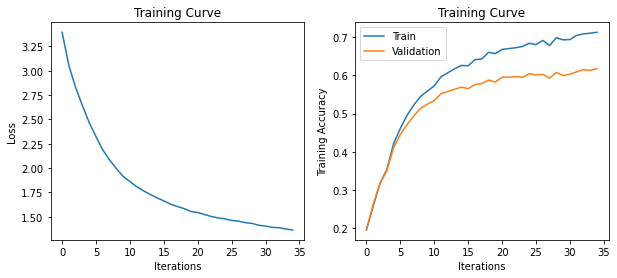

In [21]:
plot_training(iters, losses, train_acc_ls, val_acc_ls)

In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in trainset_orig.classes}
total_pred = {classname: 0 for classname in trainset_orig.classes}
y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device)
        outputs = image_classifier(images).cpu()
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[trainset_orig.classes[label]] += 1
            total_pred[trainset_orig.classes[label]] += 1

        y_pred.extend(predictions)
        y_true.extend(labels)

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class acoustic is: 45.2 %
Accuracy for class antenna is: 52.2 %
Accuracy for class bacteria is: 66.9 %
Accuracy for class battery is: 51.8 %
Accuracy for class bean  is: 53.7 %
Accuracy for class beetle is: 75.7 %
Accuracy for class bicycle is: 73.2 %
Accuracy for class birch is: 67.3 %
Accuracy for class bird  is: 41.7 %
Accuracy for class bomb  is: 57.6 %
Accuracy for class bread is: 50.7 %
Accuracy for class bridge is: 63.3 %
Accuracy for class camera is: 71.9 %
Accuracy for class carbon is: 39.0 %
Accuracy for class cat   is: 58.0 %
Accuracy for class corn  is: 49.1 %
Accuracy for class crab  is: 49.8 %
Accuracy for class crocodilian is: 56.9 %
Accuracy for class echinoderm is: 53.7 %
Accuracy for class egg   is: 55.0 %
Accuracy for class elephant is: 74.2 %
Accuracy for class fish  is: 60.4 %
Accuracy for class flower is: 93.4 %
Accuracy for class frog  is: 50.7 %
Accuracy for class fungus is: 74.6 %
Accuracy for class gauge is: 62.4 %
Accuracy for class hammer is: 75

Text(0, 0.5, 'Class')

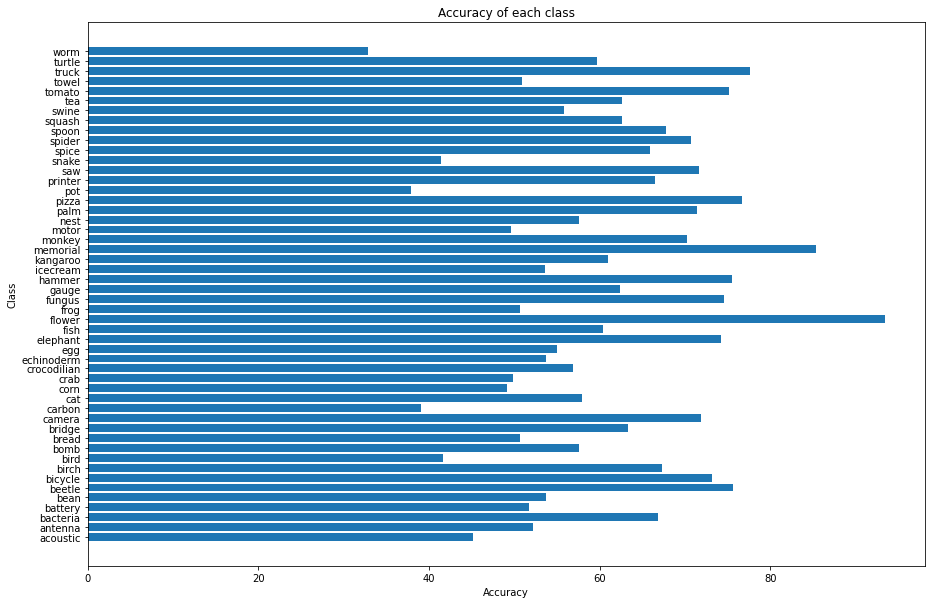

In [23]:
plt.barh(list(correct_pred.keys()), [100 * float(v) / total_pred[k] for k, v in correct_pred.items()], align='center')
plt.title('Accuracy of each class')
plt.xlabel('Accuracy')
plt.ylabel('Class')

# Make predictions

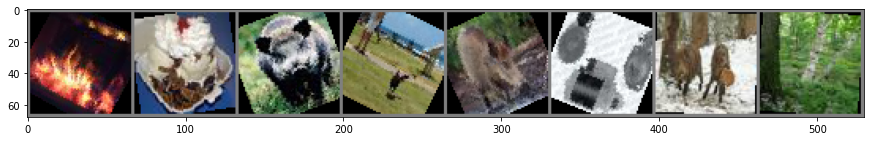

GroundTruth:  carbon icecream swine  bird swine motor swine birch


In [24]:
# get some random train images
dataiter = iter(trainloader)
random_images, random_labels = dataiter.next()
random_images = random_images[:8]

imshow(torchvision.utils.make_grid(random_images))
print('GroundTruth: ', ' '.join('%5s' % trainset_orig.classes[random_labels[j]] for j in range(8)))

In [25]:
outputs = image_classifier(random_images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % trainset_orig.classes[predicted[j]] for j in range(8)))

Predicted:  carbon icecream monkey kangaroo kangaroo printer swine birch


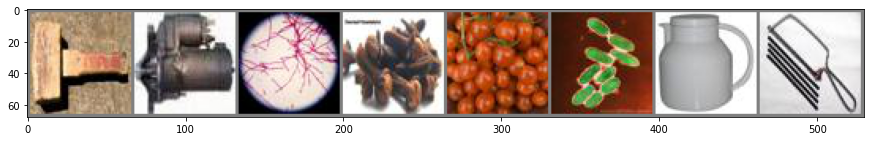

In [26]:
# get some random test images
dataiter = iter(testloader)
random_images, random_labels = dataiter.next()
random_images = random_images[:8]

imshow(torchvision.utils.make_grid(random_images))

In [27]:
outputs = image_classifier(random_images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % trainset_orig.classes[predicted[j]] for j in range(8)))

Predicted:  hammer motor towel spice tomato bacteria memorial   saw


In [28]:
with open('final_predictions.csv', 'w') as f:
    for batch_idx, data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        outputs = image_classifier(images).cpu()
        _, predictions = torch.max(outputs, 1)
        for img_idx, prediction in enumerate(predictions):
            f.write(f"{testset.imgs[(batch_size*batch_idx)+img_idx][0].replace('data/test/test_all/', '')}, {trainset_orig.class_to_idx[trainset_orig.classes[prediction.item()]]}\n")